In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys

# tidy3D import
import tidy3d as td
from tidy3d import web

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 660 * nm

# desired numerical aperture
NA = 0.8

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
rect_width = 85 * nm
rect_length = 410 * nm
lens_thick = 600 * nm
cell_length = 430 * nm

# space between PML and bottom of metalens, also space between top of metalens and PML
spacing = 1 * wavelength

# side length of entire metalens (um)
side_length = 100 * wavelength

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / cell_length)
print(f'for diameter of {(side_length / wavelength):.1f} wavelengths, have {N} cells per side')
print(f'full metalens has area of {(side_length / wavelength)**2:.1f} wavelengths^2 and {N*N} total cells')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(epsilon=1.0)
SiO2 = td.Medium(epsilon=n_SiO2**2)
TiO2 = td.Medium(epsilon=n_TiO2**2)

# resolution control
grids_per_wavelength = 18

# Number of PML layers to use along z direction
npml = 15

for diameter of 100.0 wavelengths, have 153 cells per side
full metalens has area of 10000.0 wavelengths^2 and 23409 total cells


## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation.

In [3]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
freq_0 = td.C_0 / wavelength
df = freq_0 / 40

# Define PML layers, for this we have no PML in x, y but `npml` cells in z
pml_layers = [npml, npml, npml]

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * cell_length

# focal length given diameter and numerical aperture
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)
print(f'with NA of {NA}, focal length is {(focal_length / wavelength):.2f} wavelengths or {focal_length:.2f} um')

# Function describing the theoretical best angle of each box at position (x,y).  see paper for details
def theta(x, y):
    return np.pi / wavelength * (focal_length - np.sqrt(x**2 + y**2 + focal_length**2))

length_z = spacing + lens_thick + 1.1 * focal_length + spacing

# construct simulation size array
sim_size = np.array([length_xy, length_xy, length_z])

with NA of 0.8, focal length is 37.38 wavelengths or 24.67 um


## Create Metalens Geometry

Now we can automatically generate a large metalens structure using these parameters.

We will first create the substrate

Then, we will loop through the x and y coordinates of the lens and create each unit cell

In [4]:
substrate = td.Box(
    material=SiO2,
    center=[0, 0, -length_z+spacing],
    size=[td.inf, td.inf, length_z])

# create a running list of structures
geometry = [substrate]

# define coordinates of each unit cell
centers_x = cell_length * np.arange(N) - length_xy/2. + cell_length/2.
centers_y = cell_length * np.arange(N) - length_xy/2. + cell_length/2.
center_z = -length_z/2. + spacing + lens_thick/2.

# convenience function to make an angled box at each x,y location using polyslab.
# For more details see, https://simulation.cloud/docs/html/generated/tidy3dclient.PolySlab.html
def angled_box(x, y, angle):
    """ make a box of size (L, W, H) centered at `(x, y)` at `angle` from x axis"""

    # x, y vertices of box of size (rect_length, rect_width) centered at the origin
    vertices_origin = np.array([[+rect_length/2, +rect_width/2],
                                [-rect_length/2, +rect_width/2],
                                [-rect_length/2, -rect_width/2],
                                [+rect_length/2, -rect_width/2]])
    
    # 2x2 rotation matrix angle `angle` with respect to x axis
    rotation_matrix = np.array([[+np.cos(angle), -np.sin(angle)],
                                [+np.sin(angle), +np.cos(angle)]])

    # rotate the origin vertices by this angle
    vertices_rotated = vertices_origin @ rotation_matrix
    
    # shift the rotated vertices to be centered at (x, y)
    vertices = vertices_rotated + np.array([x, y])

    # create a tidy3D PolySlab with these rotated and shifted vertices and thickness `H`
    return td.PolySlab(
            TiO2,
            vertices,
            z_cent=center_z,
            z_size=lens_thick,
            name=str(np.random.random())
        )

# loop through the coordinates and add all unit cells to geometry list
for x in centers_x:
    for y in centers_y:
        angle = theta(x, y)
        geometry.append(angled_box(x, y, angle))


In [5]:
import matplotlib

def get_patch(tidy_polyslab):
    # see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Patch.html#matplotlib.patches.Patch
    xy_vertices = tidy_polyslab.vertices
    return matplotlib.patches.Polygon(
        xy_vertices,
        capstyle='round',
        facecolor='grey',
        edgecolor='#3b3736',
        hatch=None,    
        zorder=-np.inf,
    )    

if False:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    for cell in geometry[1:]:
        ax.add_patch(get_patch(cell))
    ax.set_xlim([-length_xy / 7.0, length_xy / 7.0])
    ax.set_ylim([-length_xy / 7.0, length_xy / 7.0])
    plt.show()

## Define Sources

Now we define the incident fields.  We simply use a normally incident plane wave with Guassian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](https://simulation.cloud/docs/html/generated/tidy3dclient.PlaneWave.html#tidy3dclient.PlaneWave) and the [gaussian source documentation](https://simulation.cloud/docs/html/generated/tidy3dclient.GaussianPulse.html)

In [6]:
# Bandwidth in Hz
freq_width = freq_0 / 10.

# time dependence of source
gaussian_0 = td.GaussianPulse(freq_0, freq_width, phase=0)
gaussian_i = td.GaussianPulse(freq_0, freq_width, phase=-np.pi/2)

source_x = td.PlaneWave(
            source_time=gaussian_0,
            injection_axis='+z',
            position=-length_z/2 + 2*dl, # just next to PML
            polarization='x')
source_y = td.PlaneWave(
            source_time=gaussian_i,
            injection_axis='+z',
            position=-length_z/2 + 2*dl, # just next to PML
            polarization='y')

# circular polarization Ex + iEy
source_circ = [source_x, source_y]

# Simulation run time past the source decay
run_time = 40. / freq_width

In [7]:
min_focal_spot = wavelength / 2 / NA
efficiency_length = 6 * min_focal_spot


monitor_axis = td.FreqMonitor(
                center=[0., 0., 0],
                size=[0, 0, length_z],
                freqs=[freq_0],
                store=['E', 'H'],
                name='axis')
monitor_focal_scan = td.FreqMonitor(
                center=[0., 0., -length_z/2 + spacing + lens_thick + focal_length],
                size=[length_xy, 0, 0],
                freqs=[freq_0],
                store=['E', 'H'],
                name='focal_plane')
monitor_in = td.FreqMonitor(
                center=[0., 0., -length_z/2 + spacing -2*dl],
                size=[length_xy, length_xy, 0],
                freqs=[freq_0],
                store=['E', 'H'],
                name='incident')
monitor_near = td.FreqMonitor(
                center=[0., 0., -length_z/2 + spacing + lens_thick + spacing/2],
                size=[length_xy, length_xy, 0],
                freqs=[freq_0],
                store=['E', 'H'],
                name='near_field')
monitor_xy = td.FreqMonitor(
                center=[0., 0., -length_z/2 + spacing + lens_thick + focal_length],
                size=[length_xy, length_xy, 0],
                freqs=[freq_0],
                store=['E', 'H'],
                name='focal_plane')
monitor_eff = td.FreqMonitor(
                center=[0., 0., -length_z/2 + spacing + lens_thick + focal_length],
                size=[efficiency_length, efficiency_length, 0],
                freqs=[freq_0],
                store=['E', 'H'],
                name='focus')
monitor_CS1 = td.FreqMonitor(
                center=[0., 0., 0],
                size=[length_xy, 0, length_z],
                freqs=[freq_0],
                store=['E', 'H'],
                name='cross_section1')
monitor_CS2 = td.FreqMonitor(
                center=[0., 0., 0],
                size=[0, length_xy, length_z],
                freqs=[freq_0],
                store=['E', 'H'],
                name='cross_section2')
monitors = [monitor_axis, monitor_focal_scan, monitor_in, monitor_near, monitor_xy, monitor_eff, monitor_CS1, monitor_CS2]

## Create Simulation

Now we can put everything together and define a simulation class to be run



In [8]:
sim = td.Simulation(size=sim_size,
                    mesh_step=[dl, dl, dl],
                    structures=geometry,
                    sources=source_circ,
                    monitors=monitors,
                    run_time=run_time,
                    pml_layers=pml_layers)

Initializing simulation...
Mesh step (micron): [3.67e-02, 3.67e-02, 3.67e-02].
Simulation domain in number of grid points: [1824, 1824, 822].
Total number of grid points: 2.73e+09.
Total number of time steps: 13857.
Estimated data size (GB) of monitor monitor: 0.0000.
Estimated data size (GB) of monitor monitor_1: 0.0001.
Estimated data size (GB) of monitor monitor_2: 0.1547.
Estimated data size (GB) of monitor monitor_3: 0.1547.
Estimated data size (GB) of monitor monitor_4: 0.1547.
Estimated data size (GB) of monitor monitor_5: 0.0002.
Estimated data size (GB) of monitor monitor_6: 0.0683.
Estimated data size (GB) of monitor monitor_7: 0.0683.


## Visualize Geometry

Lets take a look and make sure everything is defined properly


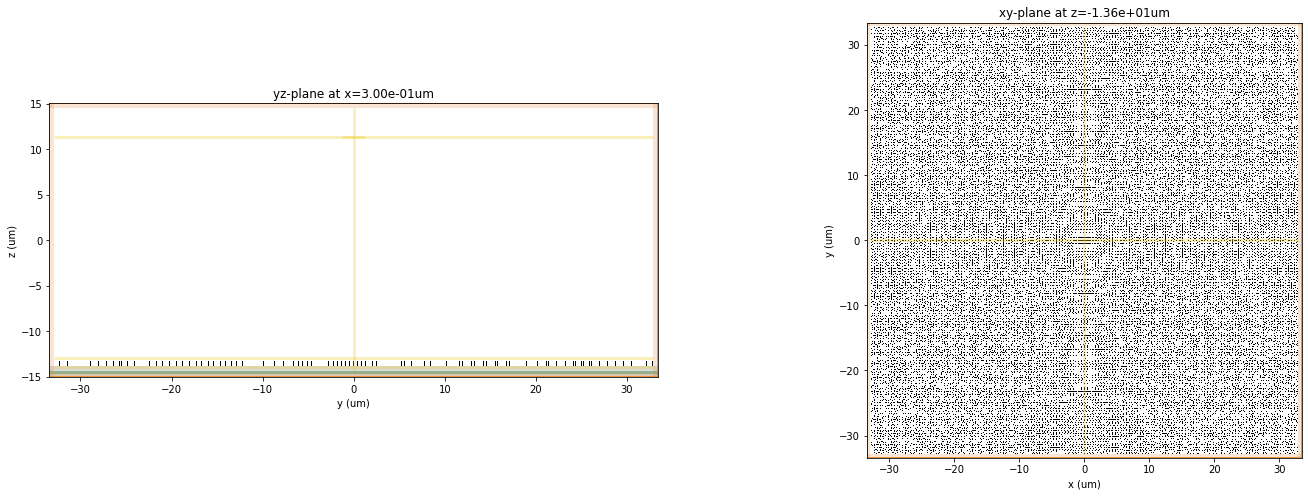

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Time the visualization of the 2D plane
td.viz.viz_eps_2D(sim, normal='x', position=0.3, ax=ax1);
td.viz.viz_eps_2D(sim, normal='z', position=-length_z/2 + spacing + lens_thick/2.0, ax=ax2);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [10]:
# Run simulation
project = web.new_project(sim.export(), task_name='metalens_measure')
web.monitor_project(project['taskId'])

# download and load the results
print('Downloading results')
web.download_results(project['taskId'], target_folder='out')
sim.load_results('out/monitor_data.hdf5')

# print stats from the logs
!cat out/tidy3d.log

Uploading the json file...
Project "metalens_measure-44-5" status: success...        

Applying source normalization to all frequency monitors using source index 0.
Simulation domain Nx, Ny, Nz: 1824, 1824, 822.
Total number of computational grid points: 2.73e+09.
Total number of time steps: 13857.
Time step: 6.355249e-17.
Starting Tidy3D... 

Setup time (s): 25.1025
- Time step    692 / time 4.40e-14fs (  5 % done), field decay: 1.00e+00
- Time step   1385 / time 8.80e-14fs ( 10 % done), field decay: 8.82e-01
- Time step   2078 / time 1.32e-13fs ( 15 % done), field decay: 5.62e-01
- Time step   2771 / time 1.76e-13fs ( 20 % done), field decay: 1.51e-01
- Time step   3464 / time 2.20e-13fs ( 25 % done), field decay: 3.06e-02
- Time step   4157 / time 2.64e-13fs ( 30 % done), field decay: 8.93e-03
- Time step   4849 / time 3.08e-13fs ( 35 % done), field decay: 1.83e-03
- Time step   5542 / time 3.52e-13fs ( 40 % done), field decay: 1.02e-05
- Time step   6235 / time 3.96e-13fs ( 45 % do

In [11]:
# download and load the results
print('Downloading results')
web.download_results(project['taskId'], target_folder='out')
sim.load_results('out/monitor_data.hdf5')

# print stats from the logs
!cat out/tidy3d.log

Applying source normalization to all frequency monitors using source index 0.
Simulation domain Nx, Ny, Nz: 1824, 1824, 822.
Total number of computational grid points: 2.73e+09.
Total number of time steps: 13857.
Time step: 6.355249e-17.
Starting Tidy3D... 

Setup time (s): 25.1025
- Time step    692 / time 4.40e-14fs (  5 % done), field decay: 1.00e+00
- Time step   1385 / time 8.80e-14fs ( 10 % done), field decay: 8.82e-01
- Time step   2078 / time 1.32e-13fs ( 15 % done), field decay: 5.62e-01
- Time step   2771 / time 1.76e-13fs ( 20 % done), field decay: 1.51e-01
- Time step   3464 / time 2.20e-13fs ( 25 % done), field decay: 3.06e-02
- Time step   4157 / time 2.64e-13fs ( 30 % done), field decay: 8.93e-03
- Time step   4849 / time 3.08e-13fs ( 35 % done), field decay: 1.83e-03
- Time step   5542 / time 3.52e-13fs ( 40 % done), field decay: 1.02e-05
- Time step   6235 / time 3.96e-13fs ( 45 % done), field decay: 4.46e-06
Field decay smaller than shutoff factor, exiting solver.
Sol

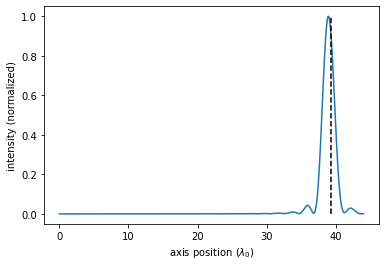

In [12]:
# intensity along axis
data_axis = sim.data(monitor_axis)
E_axis = np.squeeze(data_axis['E'])
zs = data_axis['zmesh'] + length_z / 2
I_axis = np.sum(np.square(np.abs(E_axis)), axis=0)
plt.plot(zs / wavelength, I_axis / np.max(I_axis))
z_focal = spacing + lens_thick + focal_length

plt.plot([z_focal / wavelength, z_focal / wavelength], [0, 1], 'k--')
plt.xlabel('axis position ($\lambda_0$)')
plt.ylabel('intensity (normalized)')
plt.show()

fwhm = 0.44 um, 0.67 wavelengths
fwhm_airy = 0.439999982714653


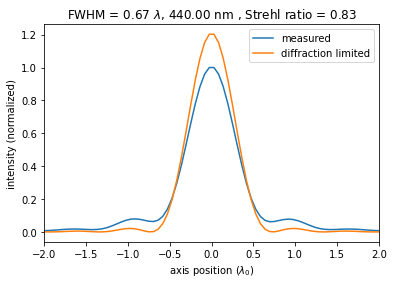

In [13]:
# intensity along focal plane
data_focus = sim.data(monitor_focal_scan)
E_focus = np.squeeze(data_focus['E'])
I_focus = np.sum(np.square(np.abs(E_focus)), axis=0)

xs = data_focus['xmesh']
I_focus = np.sum(np.square(np.abs(E_focus)), axis=0)
I_focus_normalized = I_focus / np.max(I_focus)

def FWHM(xs, Is):
    # assume uniform sampling in xs
    dx = np.mean(np.diff(xs))
    hm = np.max(Is) / 2.0
    return dx * np.sum(Is > hm)

from scipy.special import j1

def airy(xs, fwhm_desired=None):
    # FWHM = 1.028λ/D
    if fwhm_desired:
        D = 1.028 * wavelength / fwhm_desired
        c = np.pi * D / wavelength
    else:
        D = length_xy / (100 * wavelength)
        c = D*0.63 * np.pi * length_xy / wavelength
    arg = c * xs / np.sqrt(xs**2 + focal_length**2) + 1e-12
    return 1 * (j1(arg) / arg) **2

# FWHM = 1.028λ/D
# D = 1.028λ/FWHM_desired

fwhm = FWHM(xs, I_focus)
print(f'fwhm = {fwhm:.2f} um, {(fwhm / wavelength):.2f} wavelengths')

diff_lim = airy(xs)#, fwhm_desired= 0.5 * wavelength / NA)
fwhm_airy = FWHM(xs, diff_lim)
print(f'fwhm_airy = {fwhm_airy}')

energy_diff_lim = np.sum(diff_lim)
energy_measured = np.sum(I_focus_normalized)
diff_lim_normalized = diff_lim / energy_diff_lim * energy_measured
strehl_ratio = np.max(I_focus_normalized) / np.max(diff_lim_normalized)
plt.plot(xs / wavelength, I_focus_normalized, label='measured')
plt.plot(xs / wavelength, diff_lim_normalized, label='diffraction limited')
plt.legend()

plt.title(f'FWHM = {(fwhm / wavelength):.2f} $\lambda$, {(fwhm*1000):.2f} nm , Strehl ratio = {strehl_ratio:.2f}')
plt.xlabel('axis position ($\lambda_0$)')
plt.xlim([-2, 2])
plt.ylabel('intensity (normalized)')
plt.show()

In [16]:
from cmap import paper_cmap

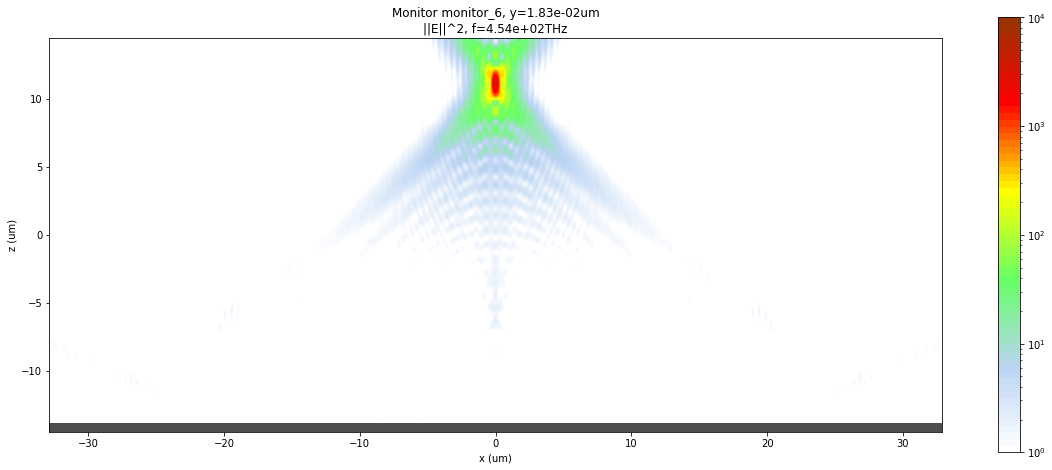

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
im = sim.viz_field_2D(monitor_CS1, eps_alpha=1, comp='z', val='int', cbar=True, ax=ax)
im.norm=LogNorm(vmin=1, vmax=10000)
im.set_cmap(paper_cmap)
plt.savefig('CS.png', dpi=400)
plt.show()

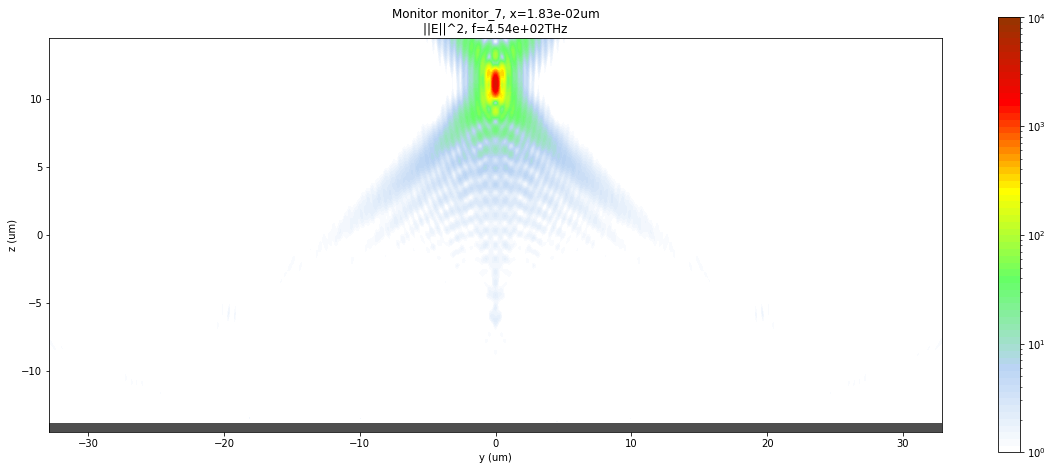

In [18]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
im = sim.viz_field_2D(monitor_CS2, eps_alpha=1, comp='z', val='int', cbar=True, ax=ax)
im.norm=LogNorm(vmin=1, vmax=10000)
im.set_cmap(paper_cmap)
plt.savefig('CS.png', dpi=400)
plt.show()

(-2.0, 2.0)

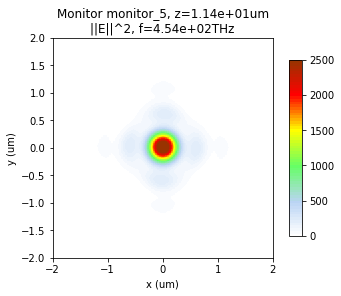

In [24]:
im = sim.viz_field_2D(monitor_eff, eps_alpha=1, comp='z', val='int', cbar=True, clim=(0, 2500))
im.set_cmap(paper_cmap)
im._axes.set_xlim(-2., 2)
im._axes.set_ylim(-2., 2)

In [25]:
power_in = sim.flux(monitor_in)[0][0]
power_near = sim.flux(monitor_near)[0][0]
power_far = sim.flux(monitor_xy)[0][0]
power_focus = sim.flux(monitor_eff)[0][0]

eff_trans = power_near / power_in
eff_far = power_far / power_in
eff_focus = power_focus / power_in

print(f'transmission efficiency = {(eff_trans*100):.2f}%')
print(f'far field efficiency = {(eff_far*100):.2f}%')
print(f'focusing efficiency = {(eff_focus*100):.2f}%')

transmission efficiency = 97.73%
far field efficiency = 82.52%
focusing efficiency = 58.78%


In [26]:
S1 = sim.poynting(monitor_xy)
S2 = sim.poynting(monitor_eff)
P_total = np.sum(S1[2,:,:,0,0])
P_fwhm = np.sum(S2[2,:,:,0,0])

In [31]:
S = S1[2,:,:,0,0]
xs = sim.data(monitor_eff)['xmesh']
ys = sim.data(monitor_eff)['ymesh']
S_total = np.sum(S)
nx, ny = S.shape
n2 = nx//2
effs = np.zeros(nx // 2)
for i in range(nx // 2):
    S_i = S[n2-i:n2+i, n2-i:n2+i]
    effs[i] = np.sum(S_i) / S_total

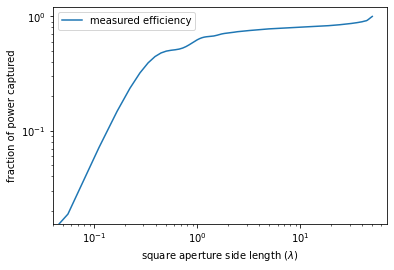

In [32]:
plt.plot(dl*np.arange(n2) / wavelength, effs, label='measured efficiency')
plt.xlabel('square aperture side length ($\lambda$)')
plt.ylabel('fraction of power captured')
plt.xscale('log')
plt.yscale('log')
plt/
plt.legend()
plt.show()
